In [46]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from torch.autograd.functional import jacobian
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Use GPU if available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [47]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dd2412-final-project ## Moving to the folder where the dataset is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/dd2412-final-project ## Moving to the folder where the dataset is stored in Google Drive'
/content/drive/MyDrive/dd2412-final-project


In [48]:
## This dataset can be downloaded at https://www.kaggle.com/datasets/diegosilvadefrana/fisical-activity-dataset

## Loading dataset
df = pd.read_csv('tabular_pe_data.csv')

## Dropping unwanted columns and rows
df = df.dropna()  # Dropping missing values
df = df[df['activityID'] != 'transient activities'] # Dropping transient activities

y = df['activityID'] # Extracating the labels

## Converting string labels to integer labels
label_to_int_dict = {l: i for i, l in enumerate(y.unique())}
df['activityID'] = df['activityID'].apply(lambda x: label_to_int_dict[x])

## Train-Validation-Test Split
train_df = df[df['PeopleId'].isin([1,2,4,5,6,8])].drop('PeopleId', axis=1)
val_df = df[df['PeopleId'] == 3].drop('PeopleId', axis=1)
test_df = df[df['PeopleId'] == 7].drop('PeopleId', axis=1)


## Feature-Label split and converting data to numpy arrays

y_train = np.array(train_df['activityID'])
X_train = np.array(train_df.drop('activityID', axis=1))

y_val = np.array(val_df['activityID'])
X_val = np.array(val_df.drop('activityID', axis=1))

y_test = np.array(test_df['activityID'])
X_test = np.array(test_df.drop('activityID', axis=1))

In [49]:
## Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


## Define PyTorch dataloaders with batch size 128
batch_size = 128

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = Data(X_val, y_val)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

## Define a dataloader to load the full test dataset at once
full_test_set_dataloader = DataLoader(dataset=test_data, batch_size=len(test_data))

In [50]:
# Define a simple feed-forward Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(31, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 13),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=31, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=13, bias=True)
  )
)


In [51]:
## Setting Training Hyperparameters

learning_rate = 0.01
weight_decay= 0.01
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

In [52]:
## Training and Validation of the Network

epochs = 1
min_valid_loss = np.inf

for e in range(epochs):
    train_acc = 0.0
    train_loss = 0.0
    for data, labels in train_dataloader:
        # Transfer Data to GPU if available
        data = data.to(device)
        labels = labels.long().to(device)

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = model(data)
        # Find the Loss
        loss = criterion(target, labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        train_acc += torch.sum(labels == target.argmax(1))/batch_size

    val_acc = 0.0
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for val_data, val_labels in val_dataloader:
        # Transfer Data to GPU if available
        val_data = val_data.to(device)
        val_labels = val_labels.long().to(device)

        # Forward Pass
        val_target = model(val_data)
        # Find the Loss
        val_loss = criterion(val_target, val_labels)
        # Calculate Loss
        valid_loss += val_loss.item()
        val_acc += torch.sum(val_labels == val_target.argmax(1))/batch_size

    print(f'Epoch {e+1} \t\t Training accuracy: {train_acc / len(train_dataloader)}\
    \t\t Validation accuracy: {val_acc / len(val_dataloader)}')
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)}\
    \t\t Validation Loss: {valid_loss / len(val_dataloader)}')

Epoch 1 		 Training accuracy: 0.852165937423706    		 Validation accuracy: 0.8033003807067871
Epoch 1 		 Training Loss: 0.4629660759478775    		 Validation Loss: 0.5721823933451646


In [53]:
## Test set evaluation

test_acc = 0.0
testing_loss = 0.0
model.eval()     # Optional when not using Model Specific layer
for test_data, test_labels in test_dataloader:
        # Transfer Data to GPU if available
        test_data = test_data.to(device)
        test_labels = test_labels.long().to(device)

        # Forward Pass
        test_target = model(test_data)
        # Find the Loss
        test_loss = criterion(test_target, test_labels)
        # Calculate Loss
        testing_loss += test_loss.item()
        test_acc += torch.sum(test_labels == test_target.argmax(1))/batch_size

print(f'Test accuracy: {test_acc / len(test_dataloader)}')

Test accuracy: 0.8455109596252441


In [54]:
def get_IxG_gradient_explanation(X, net, probs=False):
  '''
  Function that returns the Input x Gradient explanation for an input
  observation (or batch) 'X' on the neural network 'net'.
  '''
  logits = net(X)
  pred_prob = nn.Softmax(dim=1)(logits)
  y_pred = pred_prob.argmax(1)
  y_pred_oh = one_hot(y_pred, num_classes=logits.shape[1])
  external_grad = torch.reshape(y_pred_oh, logits.shape)
  X.grad = None
  if probs:
    pred_prob.backward(gradient=external_grad)
  else:
    logits.backward(gradient=external_grad)

  return X*X.grad, y_pred

Predicted Class: ascending stairs
True Class: ascending stairs


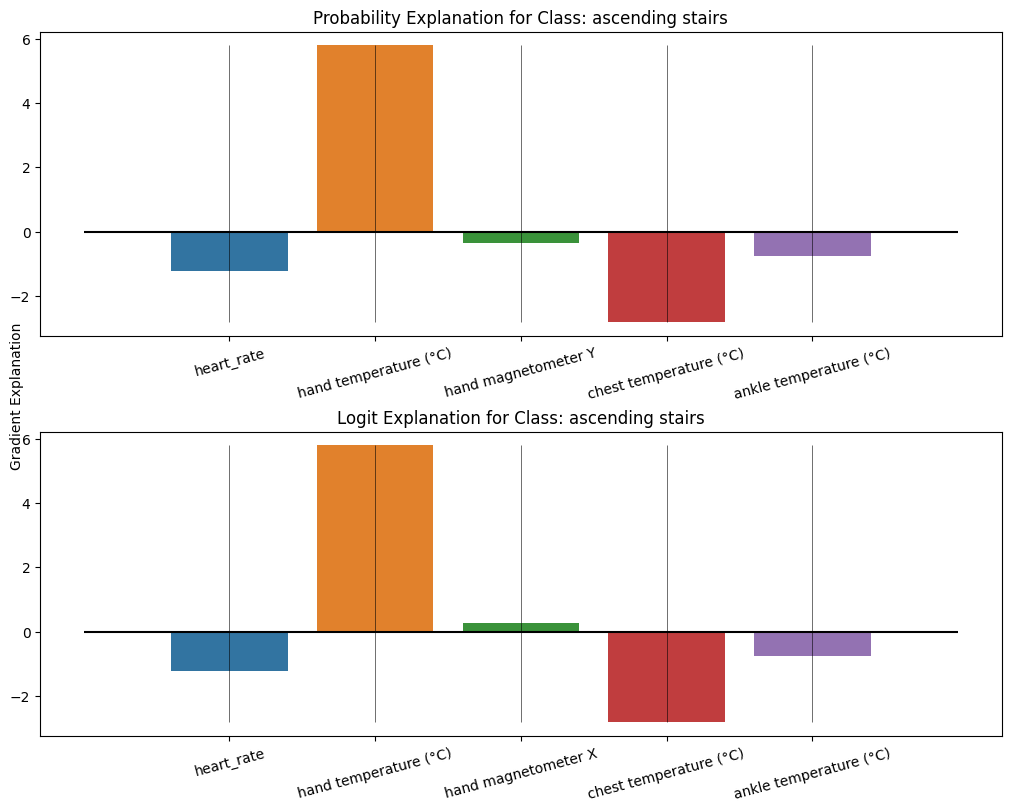

In [44]:
## Barplot visualization of individual gradient explanations

for batch_X, batch_labels in test_dataloader:
  batch_X = batch_X.to(device)
  batch_labels = batch_labels.long().to(device)
  X = batch_X[0, :]
  X = torch.reshape(X, (1, 31))
  X.requires_grad_(True)
  y = batch_labels[0]
  gradient_explanation_p, y_pred = get_IxG_gradient_explanation(X, model, probs=True)
  gradient_explanation_l, y_pred = get_IxG_gradient_explanation(X, model, probs=False)
  break

grad_p = gradient_explanation_p.cpu().detach().numpy()[0]
grad_l = gradient_explanation_l.cpu().detach().numpy()[0]
int_to_label_dict = {v: k for k, v in label_to_int_dict.items()}
predicted_class = int_to_label_dict[int(y_pred)]
true_class =  int_to_label_dict[int(y)]

print('Predicted Class:', predicted_class)
print('True Class:', true_class)

cols = train_df.drop('activityID', axis=1).columns

max_indices_p = np.argpartition(abs(grad_p), -5)[-5:]
max_indices_p = sorted(max_indices_p)

max_features_p = [cols[i] for i in max_indices_p]
grad_p_max = grad_p[max_indices_p]

max_indices_l = np.argpartition(abs(grad_l), -5)[-5:]
max_indices_l = sorted(max_indices_l)

max_features_l = [cols[i] for i in max_indices_l]
grad_l_max = grad_p[max_indices_l]


fig = plt.figure(figsize=(10, 8), layout='constrained')
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.set_title('Probability Explanation for Class: ' + str(predicted_class))
sns.barplot(x=list(range(5)), y=grad_p_max, ax=ax1)
ax1.vlines(list(range(5)), ymin=min(grad_p_max), ymax=max(grad_p_max),
           colors='black', linewidth=0.4)
ax1.hlines(y=0, xmin=-1, xmax=5, color='black')
ax1.set_xticks(range(5), max_features_p, rotation=15);

ax2.set_title('Logit Explanation for Class: ' + str(predicted_class))
sns.barplot(x=list(range(5)), y=grad_l_max, ax=ax2)
ax2.vlines(list(range(5)), ymin=min(grad_l_max), ymax=max(grad_l_max),
           colors='black', linewidth=0.4)
ax2.hlines(y=0, xmin=-1, xmax=5, color='black')
ax2.set_xticks(range(5), max_features_l, rotation=15)

ax.set_ylabel('Gradient Explanation');

In [55]:
for batch_X, batch_labels in full_test_set_dataloader:
  batch_X = batch_X.to(device)
  batch_labels = batch_labels.long().to(device)
  batch_X.requires_grad_(True)
  y = batch_labels

  gradient_explanation_l, y_pred = get_IxG_gradient_explanation(batch_X, model, probs=False)
  gradient_explanation_p, y_pred = get_IxG_gradient_explanation(batch_X, model, probs=True)


## DataFrame with Gradient Explanations towards logits for test set
df_grads_l = pd.DataFrame(gradient_explanation_l.cpu().detach().numpy())
df_grads_l.columns = cols
df_grads_l['activityID'] = y.cpu().numpy()

## DataFrame with Gradient Explanations towards probabilities for test set
df_grads_p = pd.DataFrame(gradient_explanation_p.cpu().detach().numpy())
df_grads_p.columns = cols
df_grads_p['activityID'] = y.cpu().numpy()

In [56]:
## Define a categorical colormap for the 11 classes found in the test set
map = plt.get_cmap('tab10')
new_cm_list = [t for t in map.colors]
new_cm_list.append((0,0,0))
sns.set_palette(sns.color_palette(new_cm_list))

In [81]:
from sklearn.decomposition import PCA

def get_PCA_df(df_grads):
  '''
  Projects data into 2 dimension with PCA and returns the resulting DataFrame.
  '''

  pca = PCA(n_components=2)

  X = df_grads.drop('activityID', axis=1)

  X_2D = pca.fit_transform(X)

  class_names = df_grads['activityID'].apply(lambda x: int_to_label_dict[x])

  pca_df = pd.DataFrame({'PC1': X_2D[:,0],
                        'PC2': X_2D[:,1],
                        'Class': class_names})

  return pca_df, pca

pca_df_l, pca_l = get_PCA_df(df_grads_l)
pca_df_p, pca_p = get_PCA_df(df_grads_p)

In [87]:
def get_k_largest_loadings(pca, k=3):

  df_loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'])
  df_loadings['features'] = cols
  df_loadings = df_loadings.set_index('features')
  largest_k_indices = df_loadings['PC1'].abs().nlargest(n=k).index
  df_loadings_largest = df_loadings.loc[largest_k_indices]

  return df_loadings_largest, largest_k_indices

df_loadings_largest_l, largest_k_indices_l = get_k_largest_loadings(pca_l, k=3)
df_loadings_largest_p, largest_k_indices_p = get_k_largest_loadings(pca_p, k=3)

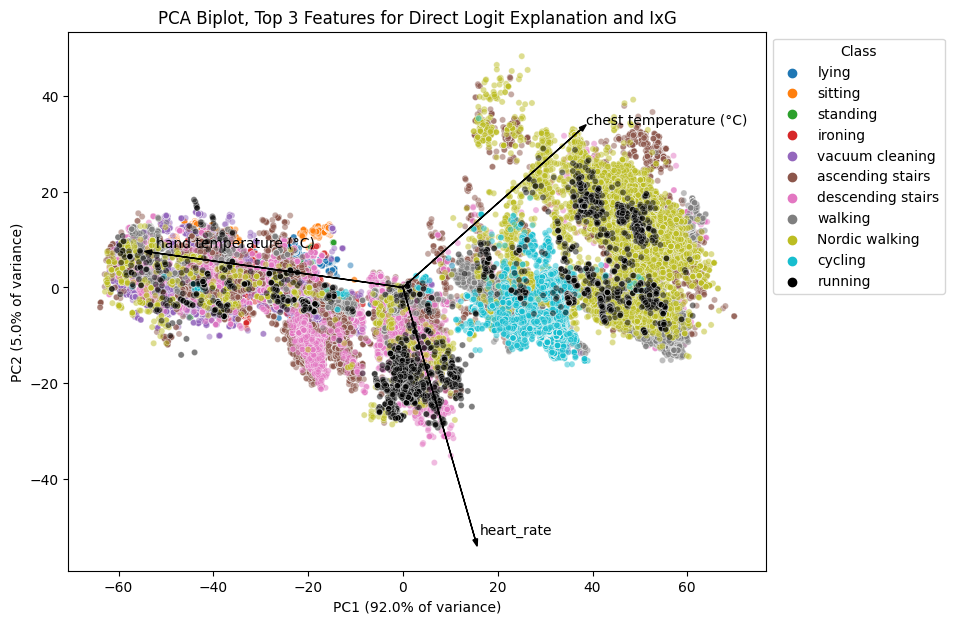

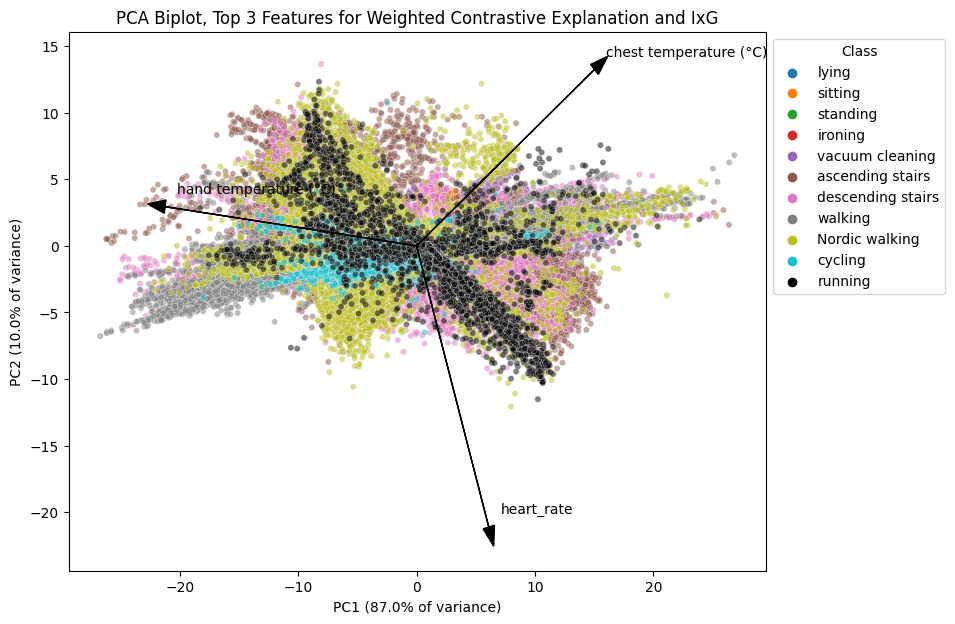

In [95]:
def plot_PCA_biplot(pca_df, pca, df_loadings_largest, largest_k_indices):

  plt.figure(figsize=(9, 7))

  ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class',
                        legend='full', s=20, alpha=0.5)
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

  # Get the loadings of x and y axes
  xs = df_loadings_largest_l['PC1']
  ys = df_loadings_largest_l['PC2']

  arrow_scale = (pca_df['PC1'].max() - pca_df['PC1'].min())/2

  # Plot the loadings on the scatterplot
  for i, varnames in enumerate(largest_k_indices):
      plt.arrow(
          0, 0, # coordinates of arrow base
          arrow_scale*xs[i], # length of the arrow along x
          arrow_scale*ys[i], # length of the arrow along y
          color='black',
          head_width=1
          )
      plt.text(arrow_scale*xs[i] + 1, arrow_scale*ys[i] + 1, varnames)

  #Define the axes
  plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0], 2)*100) + '% of variance)')
  plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1], 2)*100) + '% of variance)')

plot_PCA_biplot(pca_df_l, pca_l, df_loadings_largest_l, largest_k_indices_l)
plt.title(f'PCA Biplot, Top {len(largest_k_indices_l)} Features for Direct Logit Explanation and IxG');

plot_PCA_biplot(pca_df_p, pca_p, df_loadings_largest_p, largest_k_indices_p)
plt.title(f'PCA Biplot, Top {len(largest_k_indices_p)} Features for Weighted Contrastive Explanation and IxG');
